# A PINN of a flow through a pipe - but this time its 2D 


## Problem Setup

We consider the steady, incompressible, laminar flow of a Newtonian fluid through a nozzle-shaped pipe. The flow occurs in a 2D domain, with the **x-axis** aligned with the direction of the flow and the **y-axis** representing the transverse direction.

### Assumptions

- Steady-state flow  
- Incompressible, Newtonian fluid  
- Laminar regime (low Reynolds number)  
- No-slip boundary condition at the pipe walls  
- Known or specified pressure gradient along the pipe  

### Geometry

The pipe has a varying radius \( R(x) \), making the domain height a function of \( x \):  
\
\begin{aligned}
y \in [-R(x), R(x)]
\end{aligned}


### Governing Equations

The flow is governed by the **2D steady incompressible Navier-Stokes equations**:

\
\begin{aligned}
u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} &= -\frac{1}{\rho} \frac{\partial p}{\partial x} + \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) \\
u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} &= -\frac{1}{\rho} \frac{\partial p}{\partial y} + \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right) \\
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} &= 0 \quad \text{(Continuity)}
\end{aligned}


Where:  
- *u(x, y), v(x, y)* : velocity components in the x and y directions  
- *p(x, y)*: pressure  
- *𝜈* : kinematic viscosity  

## Neural Network

### Inputs:
- *x*, *y* : spatial coordinates in the 2D domain

### Outputs:
- *u(x, y), v(x, y)*, *p(x, y)*

### Loss Function

#### Physics Loss  
The residuals of the momentum and continuity equations are computed using automatic differentiation and evaluated over collocation points in the domain.

We will be minimizing the residuals of:

- Momentum equations in *x* and *y*:

\begin{aligned}
\mu \nabla^2 u - u \frac{\partial u}{\partial x} - v \frac{\partial u}{\partial y} + \frac{\partial p}{\partial x} = 0
\end{aligned}

\begin{aligned}
\mu \nabla^2 v - u \frac{\partial v}{\partial x} - v \frac{\partial v}{\partial y} + \frac{\partial p}{\partial y} = 0
\end{aligned}

- Continuity equation:

\begin{aligned}
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
\end{aligned}

And combine them into:

\
\begin{aligned}
L_{\text{physics}} = \text{MSE}\left( \text{Navier-Stokes residuals} + \text{continuity residual} \right)
\
\end{aligned}

#### Boundary Loss  
This enforces boundary conditions:  
- No-slip at walls: *u = v = 0*  at  *y = R(x)*  
- Inlet and outlet conditions (velocity or pressure profile):

\begin{aligned}
L_{\text{boundary}} = \text{MSE of deviations from prescribed BCs}
\end{aligned}

#### Total Loss
\begin{aligned}
L = L_{\text{physics}} + L_{\text{boundary}}
\end{aligned}


In [1]:
##################################   Environment Setup   ########################################

#Import stuff
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#Get the plotting functions
import sys
sys.path.append(r"c:\Users\nv1n24\OneDrive - University of Southampton\PhD\Research\PINNs Code\Functions")
from Plots import plot_losses, predict_and_plot, predict_and_quiver, plot_residuals, plot_velocity_profiles, validation_by_flux

#Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


##**The neural network**


In [2]:
################################### Neural Network Model   #######################################
layer_size = 100

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        #define network architecture
        self.net = nn.Sequential(
            nn.Linear(2, layer_size),        # 2 inputs (x and y)
            nn.Tanh(),
            nn.Linear(layer_size, layer_size),
            nn.Tanh(),
            nn.Linear(layer_size, layer_size),
            nn.Tanh(),
            nn.Linear(layer_size, layer_size),
            nn.Tanh(),
            nn.Linear(layer_size, layer_size),
            nn.Tanh(),
            nn.Linear(layer_size, layer_size),
            nn.Tanh(),
            nn.Linear(layer_size, 3)         # 3 outputs (x, y, pressure)
        )

    #next, define how the input flows through the network.
    # y will be taken and passed through the layers (self.net)
    def forward(self, x_y):
        out = self.net(x_y)
        return out
        

##**The Domain**

Next, the domain is defined.

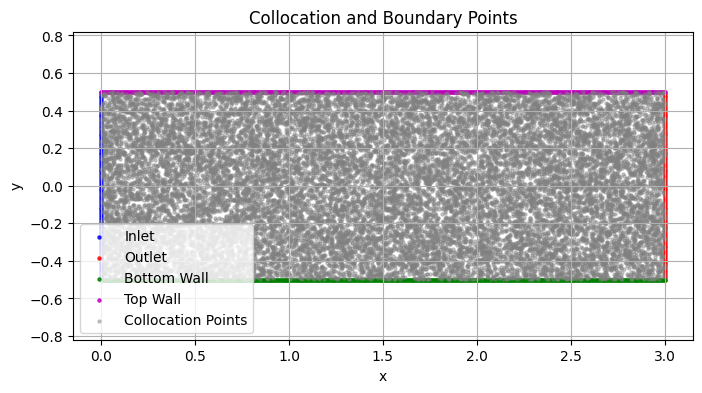

In [3]:
##############################  Boundary Points  ################################################

N_walls = 600  # numbers of points along each boundary
N_inlet = 100
N_outlet = 100

# Define the nozzle shape parameters
L_pipe = 3  # Length of the pipe
L_total = L_pipe  # Total domain length

x_vals_total = np.linspace(0, L_total, N_walls)  # x coordinates across the domain

h_total = np.zeros_like(x_vals_total)  # Initialize height array

# pipe section:
h_total[x_vals_total <= L_pipe] = 0.5  # Constant height

# Top and bottom walls:
x_y_top = np.stack([x_vals_total, h_total], axis=1)
x_y_bottom = np.stack([x_vals_total, -h_total], axis=1)

# Inlet (x=0):
y_inlet = np.linspace(-h_total[0], h_total[0], N_inlet)
x_y_inlet = np.stack([np.zeros_like(y_inlet), y_inlet], axis=1)

# Outlet (x=L_total):
y_outlet = np.linspace(-h_total[-1], h_total[-1], N_outlet)
x_y_outlet = np.stack([L_total * np.ones_like(y_outlet), y_outlet], axis=1)

# Convert to torch tensors for training use
x_y_top = torch.tensor(x_y_top, dtype=torch.float32)
x_y_bottom = torch.tensor(x_y_bottom, dtype=torch.float32)
x_y_inlet = torch.tensor(x_y_inlet, dtype=torch.float32)
x_y_outlet = torch.tensor(x_y_outlet, dtype=torch.float32)


################################## Collocation points #########################################

# Generate collocation points inside the ENTIRE domain (including straight sections)
N_collocation = 20000
x_coll = np.random.uniform(0, L_total, size=(N_collocation, 1))

# Calculate height at each collocation point using the h_total function
h_x = np.interp(x_coll.flatten(), x_vals_total, h_total)  # Use interpolation

# Ensure y_coll is strictly within the domain
margin = 1e-3
y_coll = np.random.uniform(-h_x + margin, h_x - margin)
y_coll = y_coll.reshape(x_coll.shape) # Reshape to match x_coll dimensions

x_y_collocation = np.hstack([x_coll, y_coll])
x_y_collocation = torch.tensor(x_y_collocation, dtype=torch.float32, requires_grad=True)

######################## Plot collocation and boundary points   #################################
plt.figure(figsize=(8, 4))

# Plot boundary points
plt.scatter(x_y_inlet[:, 0], x_y_inlet[:, 1], s=5, c='b', label='Inlet', alpha=0.8)
plt.scatter(x_y_outlet[:, 0], x_y_outlet[:, 1], s=5, c='r', label='Outlet', alpha=0.8)
plt.scatter(x_y_bottom[:, 0], x_y_bottom[:, 1], s=5, c='g', label='Bottom Wall', alpha=0.8)
plt.scatter(x_y_top[:, 0], x_y_top[:, 1], s=5, c='m', label='Top Wall', alpha=0.8)

# Plot collocation points
x_coll_np = x_y_collocation.detach().numpy()
plt.scatter(x_coll_np[:, 0], x_coll_np[:, 1], s=5, c='gray', label='Collocation Points', alpha=0.4)

plt.title("Collocation and Boundary Points")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
# plt.xlim(0, 0.5)
# plt.ylim(0, 0.6)
plt.grid(True)
plt.legend()
plt.show()

##**Boundary Conditions**

Define the boundary conditions at the boundaries.

 - Inlet Velocity Profile

    At the inlet *(x = 0)*, the velocity profile is parabolic:
    \
    \begin{aligned}
    u(y) = U_{\text{max}} \left(1 - \left(\frac{y}{h(0)}\right)^2\right) , v =0
    \
    \end{aligned}

    Where:
      - U_max is the peak velocity inlet
      - h(0) = 0.25 is the radius of the pipe at x = 0.


- Outlet Boundary Conditions

    At the outlet *(x = 1)*, we assume zero pressure: *p(x = 1)=0*.

    The velocities *u* and *v* can either be left as unknowns (for the model to learn), or a zero-gradient condition can be applied. For simplicity, we use: *u(x =1)=0* and *v(x=1)=0*.

- Wall Boundary Conditions (No-slip)

    For the top and bottom walls of the pipe, we apply the no-slip condition, which gives:
    \begin{aligned}
    u(y = \pm h(x)) = 0, \quad v(y = \pm h(x)) = 0
    \end{aligned}

    Where *h(x)* is the radius of the pipe at any given *x*.


In [4]:
################ Boundary condition definition  ##############################

#Inlet - a PARABOLA
U_max = 0.002
h0 = 0.5
u_inlet = U_max * (1 - (x_y_inlet[:, 1] / h0)**2).unsqueeze(1)  # make the inlet velocity a parabola (U_max at centre and 0 at sides)
#u_inlet = torch.full_like(x_y_inlet[:, 1].unsqueeze(1), U_max)  # inlet velocity is a constant
v_inlet = torch.zeros_like(u_inlet)   # velocity in y is zero for the input
p_inlet = torch.zeros_like(u_inlet)  # optional, can be ignored or fixed to 0

target_inlet = torch.cat([u_inlet, v_inlet, p_inlet], dim=1).to(device)

# Outlet, pressure outlet
p_outlet = torch.zeros((x_y_outlet.shape[0], 1))
u_outlet = torch.zeros_like(p_outlet)
v_outlet = torch.zeros_like(p_outlet)

target_outlet = torch.cat([u_outlet, v_outlet, p_outlet], dim=1).to(device)

# def compute_normals(coords):
#     dx = torch.gradient(coords[:, 0])[0] # change in x
#     dy = torch.gradient(coords[:, 1])[0] # change in y
#     tangents = torch.stack([dx, dy], dim=1) # get tangent
#     normals = torch.stack([-tangents[:, 1], tangents[:, 0]], dim=1)  # Rotate tangents 90° to get the normals
#     normals = torch.nn.functional.normalize(normals, dim=1)  #normalize to unit length
#     return normals

##**The loss functions**

Here the physics and the boundary loss are defined. Then, inside the train_pinn loop they are combined into the total loss.

In [5]:
#################################### Physics loss  ########################################################
def physics_loss(model, x_y, Re):
    x_y.requires_grad_(True)
    out = model(x_y)    #predict the velocities
    u = out[:, 0:1]     #get the velocity in x
    v = out[:, 1:2]     #get the velocity in y
    p = out[:, 2:3]     #get the pressure

    # Compute gradients
    grads = lambda f, wrt: torch.autograd.grad(f, wrt, grad_outputs=torch.ones_like(f), create_graph=True)[0]

    du_dx = grads(u, x_y)[:, 0:1]
    du_dy = grads(u, x_y)[:, 1:2]
    dv_dx = grads(v, x_y)[:, 0:1]
    dv_dy = grads(v, x_y)[:, 1:2]
    dp_dx = grads(p, x_y)[:, 0:1]
    dp_dy = grads(p, x_y)[:, 1:2]

    d2u_dx2 = grads(du_dx, x_y)[:, 0:1]
    d2u_dy2 = grads(du_dy, x_y)[:, 1:2]
    d2v_dx2 = grads(dv_dx, x_y)[:, 0:1]
    d2v_dy2 = grads(dv_dy, x_y)[:, 1:2]

    # Residuals of Navier-Stokes
    momentum_x = - 1 / Re  * (d2u_dx2 + d2u_dy2) + u * du_dx + v * du_dy + dp_dx
    momentum_y = - 1 / Re  * (d2v_dx2 + d2v_dy2) + u * dv_dx + v * dv_dy + dp_dy
    continuity = du_dx + dv_dy


    # Summing the mean squared residuals of the three residuals 
    loss = torch.mean(momentum_x**2) + torch.mean(momentum_y**2) + torch.mean(continuity**2) 
    return loss

########################################## Boundary loss  ################################################
def boundary_loss(model, x_y_inlet, x_y_outlet, x_y_top, x_y_bottom,
                  target_inlet, target_outlet):
    # Predict
    pred_inlet = model(x_y_inlet)
    pred_outlet = model(x_y_outlet)
    pred_top = model(x_y_top)
    pred_bottom = model(x_y_bottom)
    

    # Inlet: match u, v (no p)
    inlet_loss = torch.mean((pred_inlet[:, 0:1] - target_inlet[:, 0:1])**2) + \
                 torch.mean((pred_inlet[:, 1:2] - target_inlet[:, 1:2])**2)

    # Outlet:
    outlet_loss = torch.mean((pred_outlet[:, 2:3] - target_outlet[:, 2:3])**2)

    # No-slip at walls: u = 0, v = 0 (in global coordinates)
    wall_loss = torch.mean(pred_top[:, 0:2]**2) + torch.mean(pred_bottom[:, 0:2]**2)

    loss = inlet_loss + wall_loss + outlet_loss

    return loss

######################################### Pressure anchor loss  ################################################
def pressure_anchor_loss(model):

    x_y_anchor = torch.tensor([[L_total, 0.0]], dtype=torch.float32)
    x_y_anchor = x_y_anchor.to(device)
    x_y_anchor.requires_grad_(True)
    pred_anchor = model(x_y_anchor)
    anchor_loss = torch.mean((pred_anchor[:, 2:3])**2)
    
    return anchor_loss



##**The network training loop and a prediction**

Epoch 0 | Total Loss: 1.5686e+03 | Phys: 7.1005e+00 | BC: 1.5567e+03 | Anchor: 4.7674e+00


c:\Users\nv1n24\OneDrive - University of Southampton\PhD\Research\PINNs Code\Functions\Plots.py:108: UserWarning: Adding colorbar to a different Figure <Figure size 500x200 with 2 Axes> than <Figure size 500x200 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(all_contours_v[0], ax=ax1, label="Velocity Magnitude [m/s]")


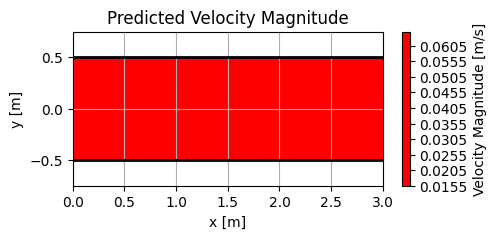

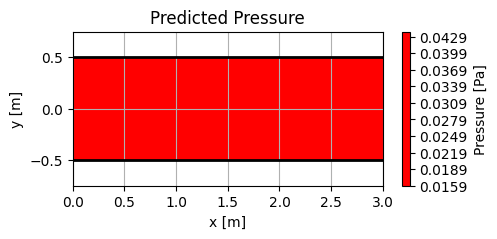

Epoch 1000 | Total Loss: 8.9950e-01 | Phys: 6.3717e-03 | BC: 8.9188e-01 | Anchor: 1.2470e-03


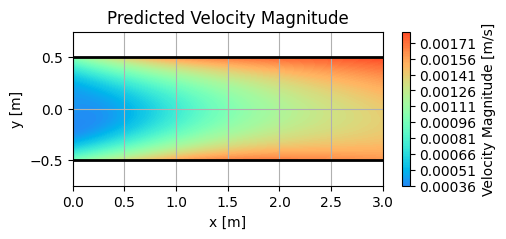

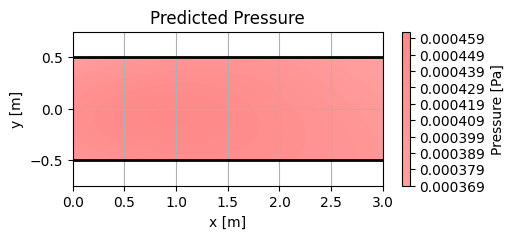

Epoch 2000 | Total Loss: 2.1379e-01 | Phys: 7.0590e-04 | BC: 1.0883e-01 | Anchor: 1.0426e-01


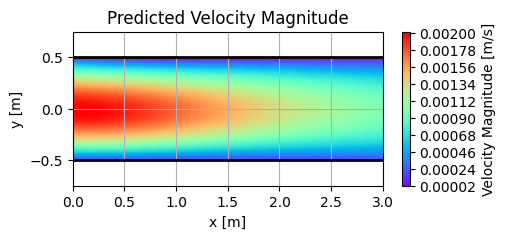

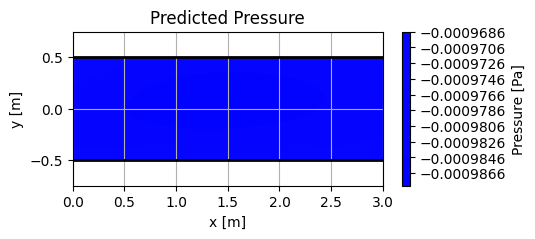

Epoch 3000 | Total Loss: 1.3157e-01 | Phys: 1.0184e-03 | BC: 1.2890e-01 | Anchor: 1.6506e-03


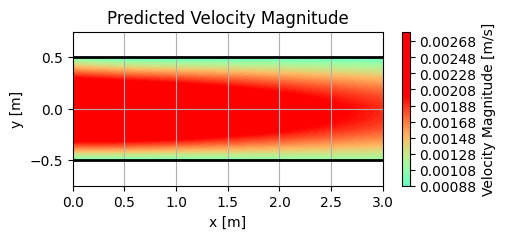

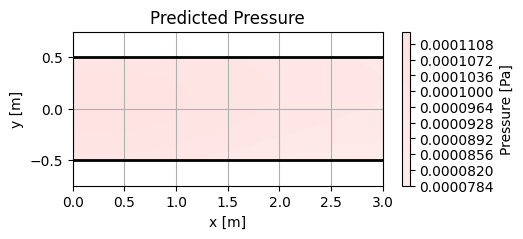

Epoch 4000 | Total Loss: 2.8975e-02 | Phys: 3.8924e-04 | BC: 2.8171e-02 | Anchor: 4.1524e-04


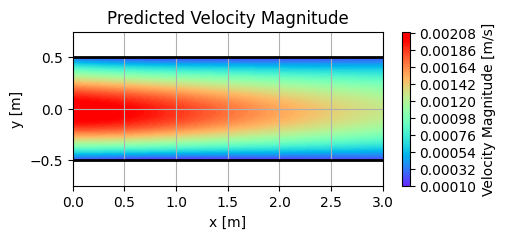

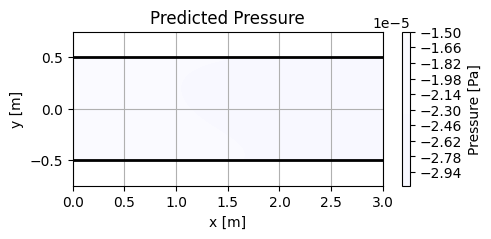

Epoch 5000 | Total Loss: 1.6124e-02 | Phys: 1.0582e-03 | BC: 1.5063e-02 | Anchor: 2.7581e-06


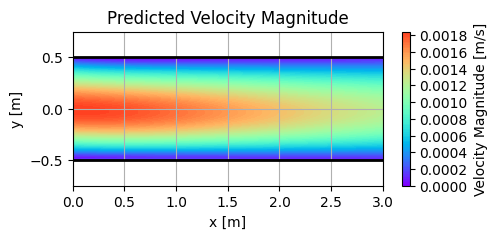

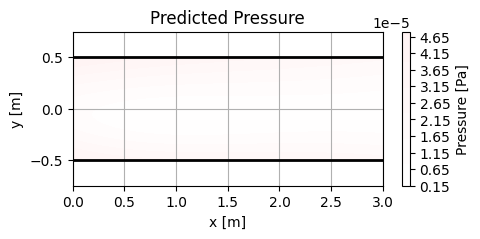

Epoch 6000 | Total Loss: 7.7964e-03 | Phys: 1.8224e-04 | BC: 7.6036e-03 | Anchor: 1.0570e-05


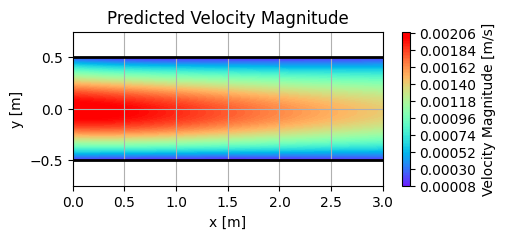

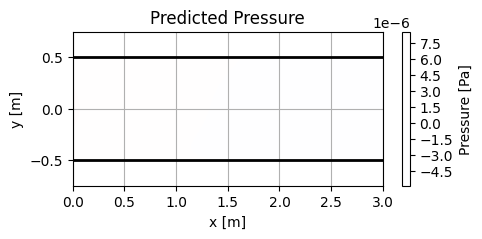

Epoch 7000 | Total Loss: 1.1827e-02 | Phys: 1.4864e-04 | BC: 1.1634e-02 | Anchor: 4.3965e-05


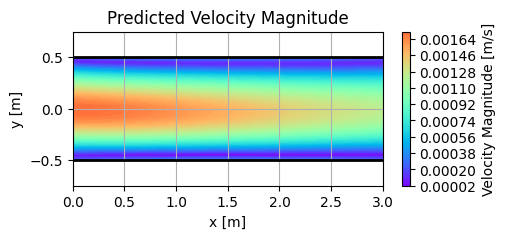

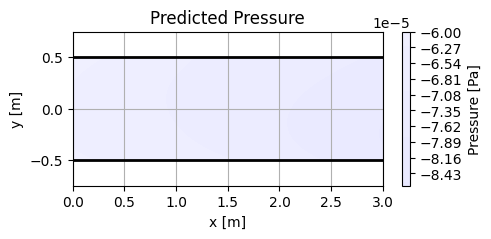

Epoch 8000 | Total Loss: 2.4376e-03 | Phys: 7.7416e-05 | BC: 1.4067e-03 | Anchor: 9.5352e-04


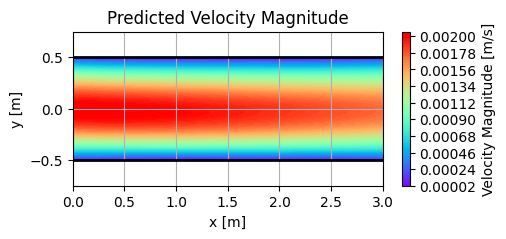

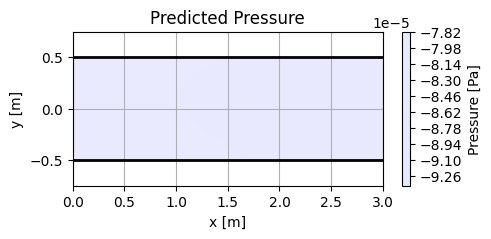

Epoch 9000 | Total Loss: 1.4512e-03 | Phys: 5.7338e-05 | BC: 1.0704e-03 | Anchor: 3.2339e-04


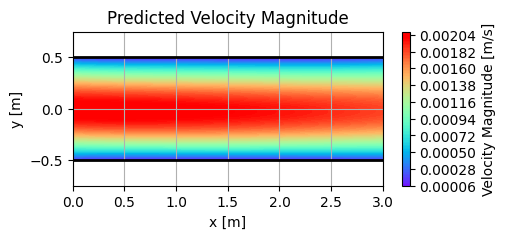

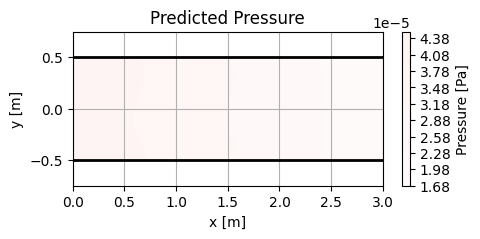

Epoch 10000 | Total Loss: 2.4469e-04 | Phys: 4.1711e-05 | BC: 2.0276e-04 | Anchor: 2.2427e-07


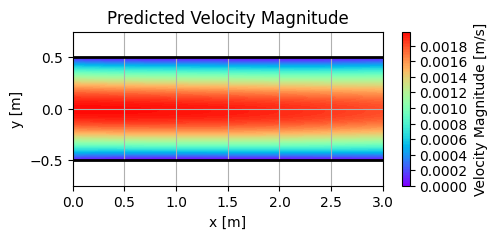

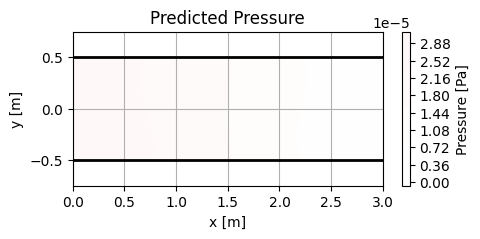

Epoch 11000 | Total Loss: 1.0930e-03 | Phys: 1.5620e-05 | BC: 1.0737e-03 | Anchor: 3.7042e-06


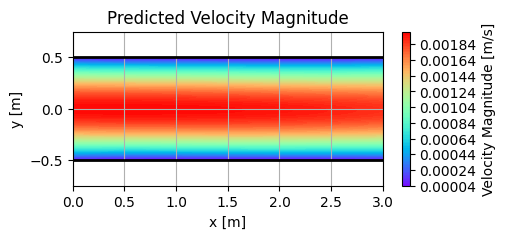

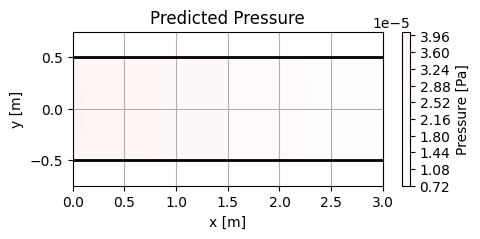

Epoch 12000 | Total Loss: 2.8391e-04 | Phys: 1.1676e-05 | BC: 2.7011e-04 | Anchor: 2.1218e-06


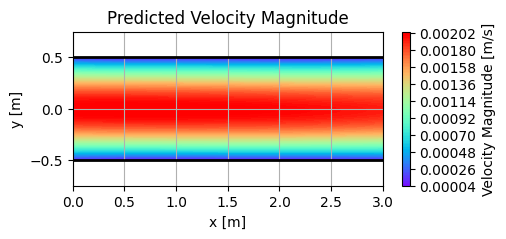

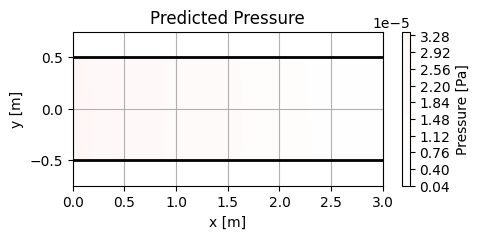

Epoch 13000 | Total Loss: 1.2347e-04 | Phys: 5.7921e-06 | BC: 1.1766e-04 | Anchor: 2.3363e-08


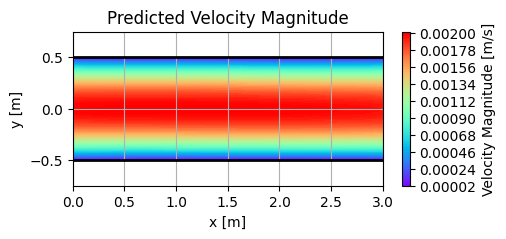

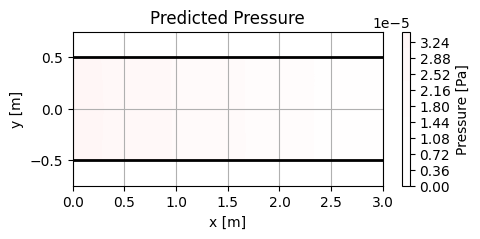

Epoch 14000 | Total Loss: 1.2445e-04 | Phys: 4.5341e-06 | BC: 1.1982e-04 | Anchor: 9.9304e-08


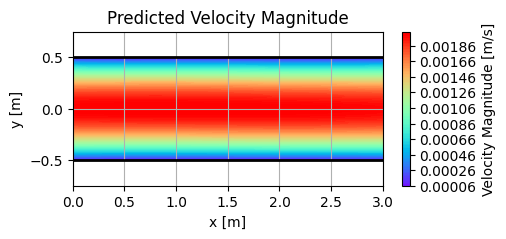

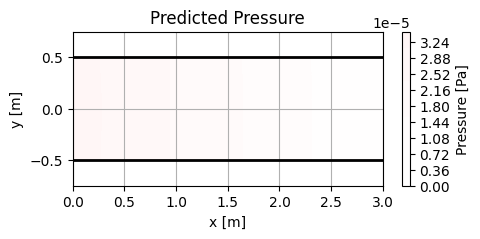

Epoch 15000 | Total Loss: 1.3846e-04 | Phys: 4.9255e-06 | BC: 1.3350e-04 | Anchor: 2.8977e-08


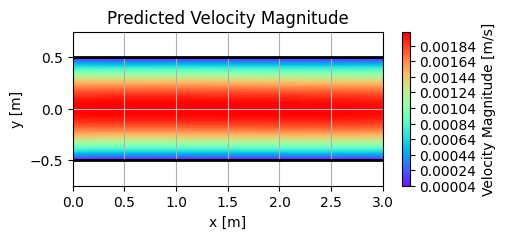

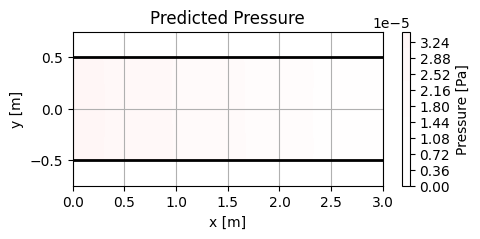

Epoch 16000 | Total Loss: 2.9552e-05 | Phys: 3.8959e-06 | BC: 2.5651e-05 | Anchor: 4.5089e-09


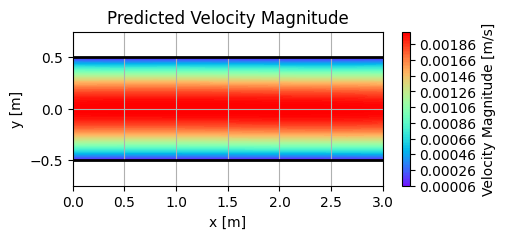

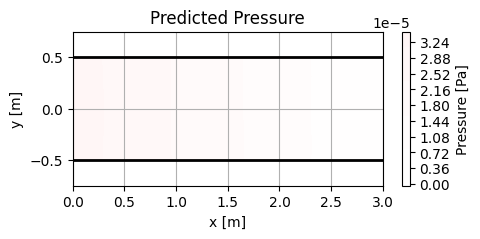

Epoch 17000 | Total Loss: 1.2388e-05 | Phys: 2.4662e-06 | BC: 9.9046e-06 | Anchor: 1.7022e-08


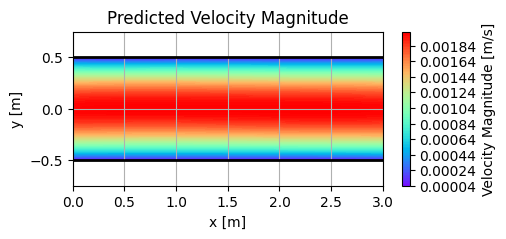

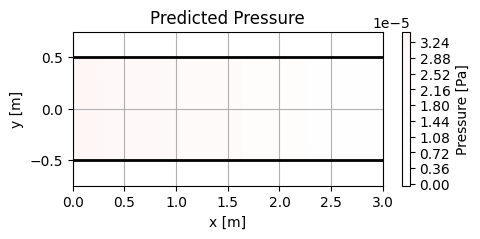

Epoch 18000 | Total Loss: 9.9830e-06 | Phys: 1.4759e-06 | BC: 6.1446e-06 | Anchor: 2.3625e-06


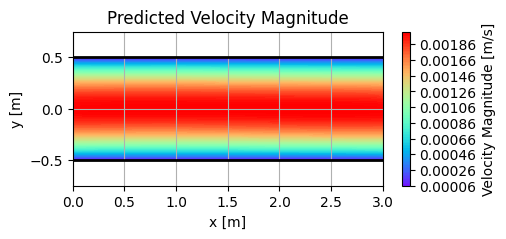

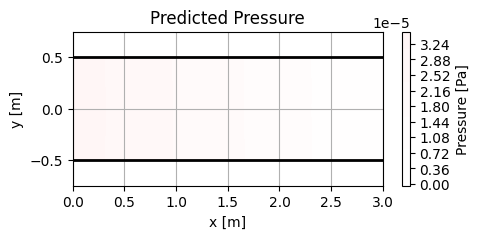

Epoch 19000 | Total Loss: 6.1128e-06 | Phys: 9.3558e-07 | BC: 5.1400e-06 | Anchor: 3.7212e-08


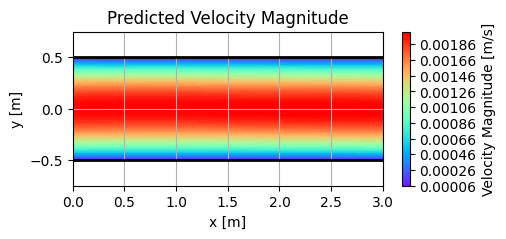

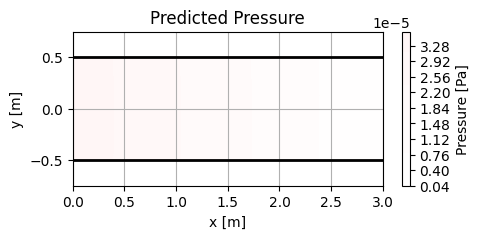

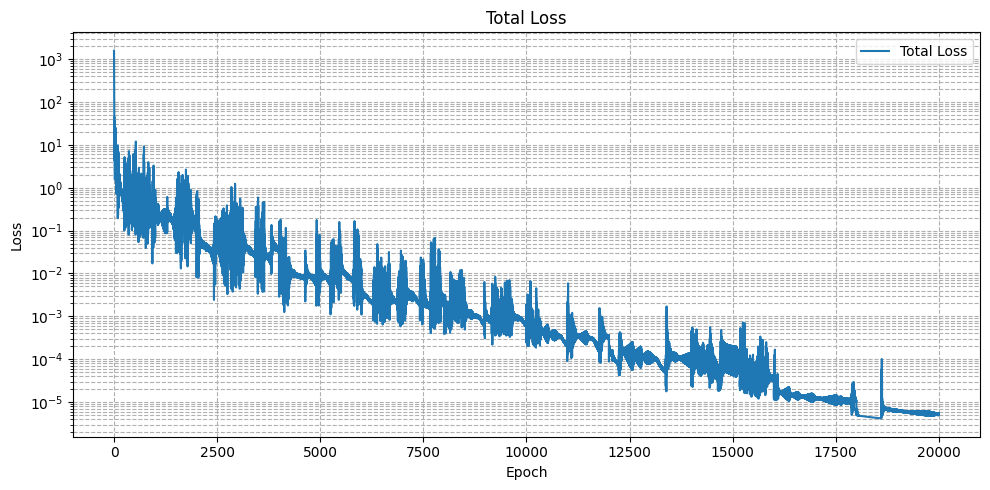

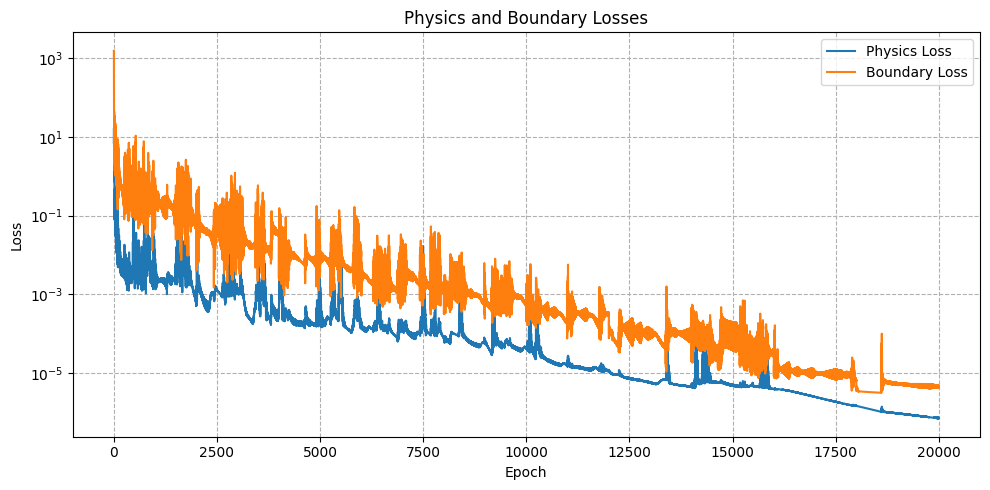

In [6]:
#Move to GPU
x_y_collocation = x_y_collocation.to(device)
#x_y_boundary = x_y_boundary.to(device)
x_y_top = x_y_top.to(device)
x_y_bottom = x_y_bottom.to(device)
x_y_inlet = x_y_inlet.to(device)
x_y_outlet = x_y_outlet.to(device)

#normals_top = compute_normals(x_y_top)
#normals_bottom = compute_normals(x_y_bottom)

#### Load the pre-trained model if loading from the saved file
#model = PINN().to(device)
#model.load_state_dict(torch.load('trained_pinn_model.pth'))

epoch_start = 0
epoch_end = 20000
lr_drop_epoch=2000

sections = [
        ("Pipe", 0.0, 3.0)
    ]

#################################  Training Loop  #########################################

def train_pinn(model, x_y_collocation, x_y_inlet, x_y_outlet, x_y_top, x_y_bottom,Re,
                      epoch_start=epoch_start, epoch_end = epoch_end, lr_drop_epoch=lr_drop_epoch, optimizer=None):

    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_drop_epoch, gamma=0.5)

    x_y_collocation.requires_grad_(True)

    loss_history = []
    physics_loss_history = []
    boundary_loss_history = []
    anchor_loss_history = []

    for epoch in range(epoch_start,epoch_end):
        optimizer.zero_grad()

        # Weighting terms
        lambda_phys = 1.0 *10.0**5
        lambda_bc = 1.0 *10.0**5
        lambda_anchor = 1.0 *10.0**5

        # Compute losses
        loss_phys = lambda_phys * physics_loss(model, x_y_collocation, Re)
        loss_bc = lambda_bc * boundary_loss(model, x_y_inlet, x_y_outlet, x_y_top, x_y_bottom,
                  target_inlet, target_outlet)
        loss_anchor = lambda_anchor * pressure_anchor_loss(model)  

        # Total loss
        total_loss = loss_bc + loss_phys  + loss_anchor

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        # Log
        loss_history.append(total_loss.item())
        physics_loss_history.append(loss_phys.item())
        boundary_loss_history.append(loss_bc.item())
        anchor_loss_history.append(loss_anchor.item())

        if epoch % 1000 == 0:
            print(f"Epoch {epoch} | Total Loss: {total_loss.item():.4e} | Phys: {loss_phys.item():.4e} | BC: {loss_bc.item():.4e} | Anchor: {loss_anchor.item():.4e}")  

        if epoch % 1000 == 0:
            fig1 = predict_and_plot(model, device, sections, x_vals_total, h_total, min_vel=0, max_vel=0.002, min_pres=-0.001, max_pres=0.001)
            torch.save({
                            'epoch': epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': total_loss
                        }, 'trained_pinn_pipe.pth')   # save the model for later re-loading

    return model, loss_history, physics_loss_history, boundary_loss_history, anchor_loss_history ,optimizer

#########################   Run the training and plot the plots  ##########################
L_ref = 3.0 # Reference length for non-dimensionalization
D_ref = 1.0  # Reference diameter for non-dimensionalization
U_ref = 0.002  # Reference velocity for non-dimensionalization
U_mean = (2/3) * U_ref  # Mean velocity for the pipe flow, assuming parabolic profile
rho = 1000.0  # Density of water for non-dimensionalization
mu = 0.001   # Dynamic viscosity of water for non-dimensionalization
nu = mu / rho  # Kinematic viscosity
#Re = rho * U_mean * L_ref / mu # general Reynolds number
Re = U_mean *  D_ref / nu #pipe flow Reynolds number


model = PINN().to(device)
trained_model, loss_history, physics_loss_history, boundary_loss_history, anchor_loss_history, optimizer = train_pinn(
    model,
    x_y_collocation,
    x_y_inlet,
    x_y_outlet,
    x_y_top,
    x_y_bottom,
    #normals_top,
    #normals_bottom,
    Re,
    epoch_start=epoch_start,
    epoch_end=epoch_end,
    lr_drop_epoch=lr_drop_epoch
    )

final_epoch = epoch_end - 1  # Last epoch index
final_loss = loss_history[-1]  # Last loss value

torch.save({
    'epoch': final_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': final_loss
}, 'trained_pinn_pipe.pth')   # save the model to train longer later

plot_losses("Total Loss",
                    **{
                        "Total Loss": loss_history
                    })

plot_losses("Physics and Boundary Losses",
                    **{
                        "Physics Loss": physics_loss_history,
                        "Boundary Loss": boundary_loss_history
                    })

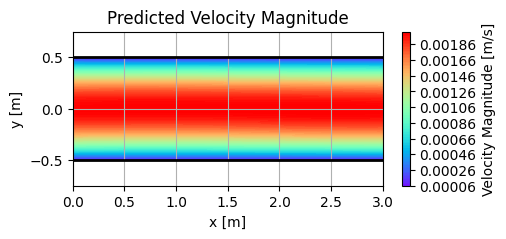

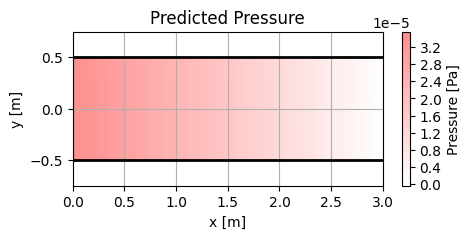

In [13]:
fig1, fig2 = predict_and_plot(trained_model, device, sections, x_vals_total, h_total, min_vel=0, 
                              max_vel=0.002, min_pres=-0.00008, max_pres=0.00008)

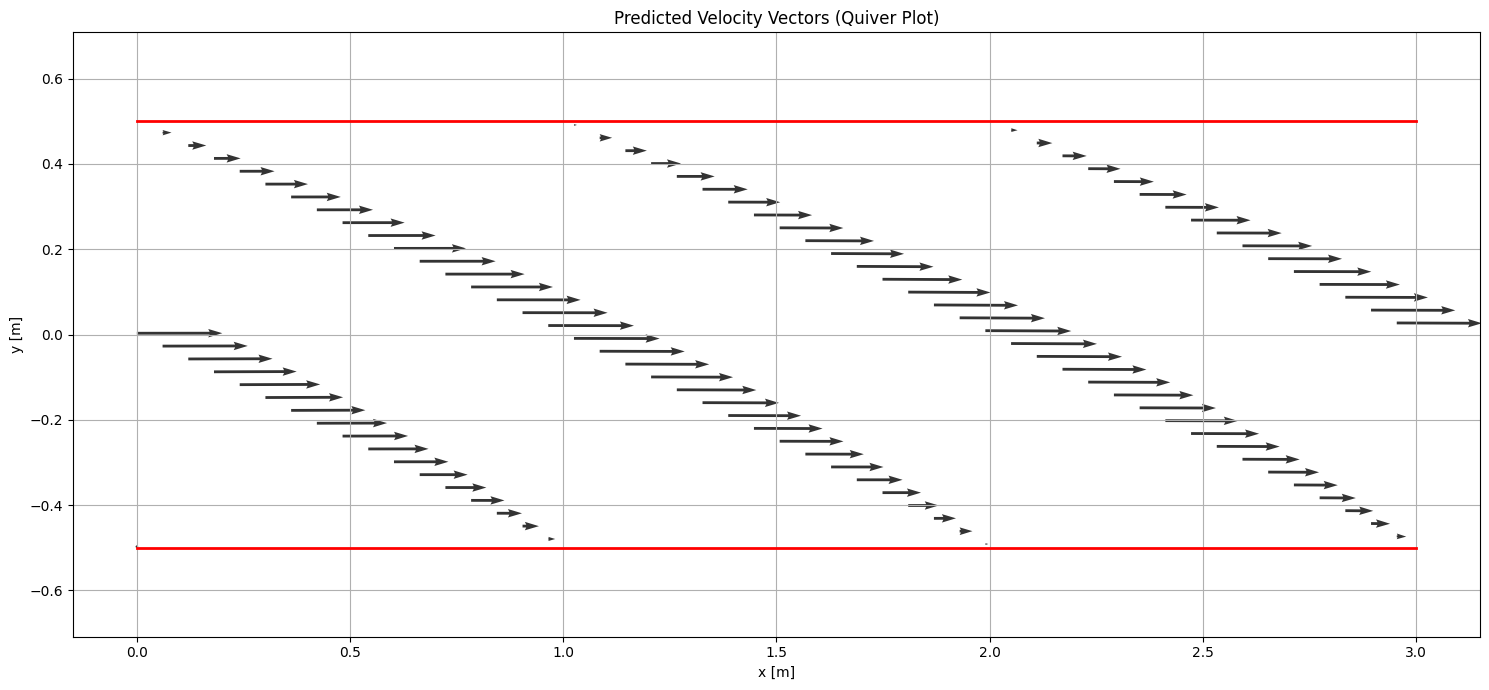

In [8]:
fig_quiver = predict_and_quiver(trained_model, device, sections, x_vals_total=x_vals_total, 
                                h_total=h_total, density=100, scale=0.01, xlim=None, ylim=None, ymin=-0.6, ymax=0.6, y_density=200)

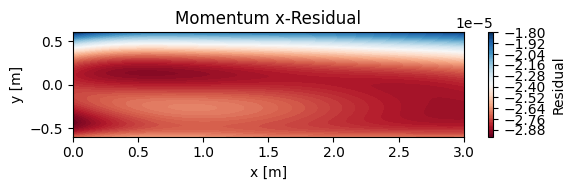

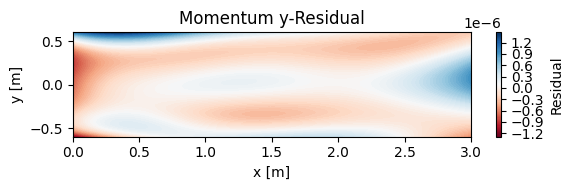

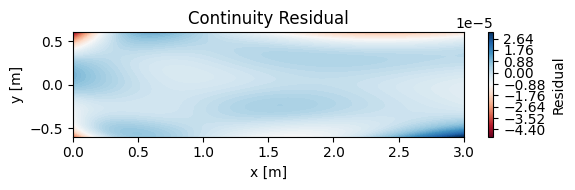

Inlet max velocity: 0.0020040287636220455
Outlet max pressure: 3.334134817123413e-07
Wall top max velocity: 1.556693132442888e-05
Wall bottom max velocity: 1.4364309208758641e-05


In [9]:
plot_residuals(trained_model, device, x_range= (0,3), y_range = (-0.6, 0.6), x_points = 200, y_points = 100,
                   x_y_inlet=x_y_inlet, x_y_outlet=x_y_outlet, x_y_top=x_y_top, x_y_bottom=x_y_bottom)

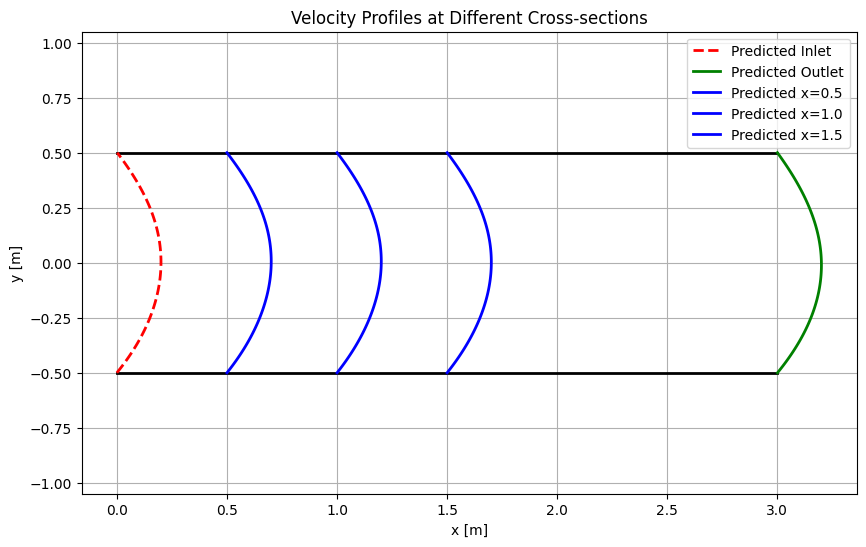

<module 'matplotlib.pyplot' from 'c:\\Users\\nv1n24\\OneDrive - University of Southampton\\PhD\\Research\\PINNs Code\\PINNsEnv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [10]:
x_locs= [0.5, 1.0, 1.5]

plot_velocity_profiles(trained_model, device, x_vals_total=x_vals_total, h_total=h_total, L_total=L_total, x_y_inlet=x_y_inlet, 
                       x_y_outlet=x_y_outlet, x_locs=x_locs, scale=100)

In [11]:
validation_by_flux(trained_model, x_vals_total, h_total, L_total)

Volumetric flow rate at inlet:  0.001336
Volumetric flow rate at outlet: 0.001334
Relative difference: 0.14%


In [12]:
crash crash crash

SyntaxError: invalid syntax (2016411700.py, line 1)

##**Continue training**

If more epochs are needed, train some more

In [ ]:
########################  Train Longer!   ###################################################

#### Load the pre-trained model 
model = PINN().to(device)

checkpoint = torch.load('trained_pinn_pipe.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch_start = checkpoint['epoch'] + 1  # Continue from last epoch
loss = checkpoint['loss']

epoch_end = epoch_start + 10000  # Train for X more epochs

# Continue training
trained_model, new_loss_history, new_physics_loss_history, new_boundary_loss_history, new_anchor_loss_history, optimizer = train_pinn(
    model,
    x_y_collocation,
    x_y_inlet,
    x_y_outlet,
    x_y_top,
    x_y_bottom,
    Re,
    epoch_start=epoch_start,  ## start where the previous one left off
    epoch_end = epoch_end,
    lr_drop_epoch=2000,
    optimizer=optimizer  # Keep or adjust the lr scheduler
)

# If you have previous histories, extend them. Otherwise, just use the new ones.
try:
    loss_history.extend(new_loss_history)
    physics_loss_history.extend(new_physics_loss_history)
    boundary_loss_history.extend(new_boundary_loss_history)
    anchor_loss_history.extend(new_anchor_loss_history)
except NameError:
    loss_history = new_loss_history
    physics_loss_history = new_physics_loss_history
    boundary_loss_history = new_boundary_loss_history
    anchor_loss_history = new_anchor_loss_history

torch.save({'epoch': epoch_end - 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_history[-1]},
            'trained_pinn_pipe.pth')   # save the model for later re-loading

plot_losses("Total Loss",
                    **{
                        "Total Loss": loss_history
                    })

plot_losses("Physics and Boundary Losses",
                    **{
                        "Physics Loss": physics_loss_history,
                        "Boundary Loss": boundary_loss_history
                    })

